# kCSD-python package tutorial

In this tutorial we illustrate the use of kCSD-python package for CSD reconstruction in the simplest case of a regular 2D square grid. This is a simplified version of a slice on a microelectrode array [Ness et al., 2015], or a planar silicone probe within the brain, where we assume constant conductivity in the whole space.

We start with the basic CSD estimation on a regular grid. First, we define a region of interest. Then, using predefined test functions for the current sources, we place a ground truth current source in this region. We define the distribution of electrodes. Assuming ideal electrodes, we compute the potential generated by the selected current sources as measured at the electrodes. Given these potentials and the electrode locations we estimate the current source density using kCSD (Basic features). In the second part of this tutorial, we explore noisy electrodes and test the robustness of the method (Noisy electrodes). In the final part we look at how the errors in the estimation depend on the sources and the electrode configuration by testing the effect of broken electrodes on reconstruction (Broken electrodes).

## Basic features
In this tutorial we illustrate the use of kCSD package for CSD reconstruction in the simplest case of a regular 2D square grid. The following steps, will take us through this.
1. Define a region of interest - a unit square as the test bench
2. Place one of predefined current sources in this region
3. Define electrode configuration in the the region of interest
4. Assuming ideal electrodes, obtain the potential generated at the electrodes by the introduced current sources
5. Estimate current source density from the measured potentials given the electrode locations and using the default parameters
6. Perform cross validation to improve the estimate and avoid overfitting

### Region of interest

In [1]:
%matplotlib inline
import numpy as np
csd_at = np.mgrid[0.:1.:100j,                                                                                                                                                           
                  0.:1.:100j]
csd_x, csd_y = csd_at

We use the `numpy` Python library, and define a 2 dimensional grid using the `mgrid` function. We define the region of interest between `0` and `1` in the `xy` plane, with a resolution of `100` points in each dimension (as indicated by `100j`). The units we will assume are in $mm$. The first line starting with the `%` is to ensure the plots using this tutorial are displayed correctly.

### Predefined current sources for testing

In [2]:
from kcsd import csd_profile as CSD
CSD_PROFILE = CSD.gauss_2d_small
true_csd = CSD_PROFILE(csd_at, seed=15) 

The `kCSD-python` library provides functions to generate test sources which can be imported from the `csd_profile` module. Here we use the `gauss_2d_small` function to generate two-dimensional Gaussian sources which are small in the scale set by the interelectrode distance. The other implemented option for two-dimensional test sources is the `gauss_2d_large` function. To generate the exact same sources in each run we must invoke these functions using the same random seed which is stored in the seed variable. For simplicity, these current sources are static and do not change with time. 
***
We visualize the current sources as a heatmap. Note that changing the `seed`, or the source type to `gauss_2d_large`, changes the type of the current sources generated. The code below displays this test source as the True CSD. For convenience we define this as a function `make_plot`.

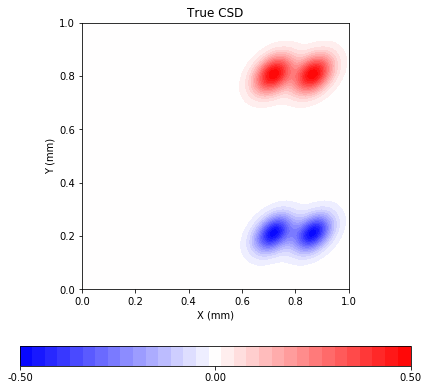

In [3]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

def make_plot(xx, yy, zz, title='True CSD', cmap=cm.bwr):
    fig = plt.figure(figsize=(7, 7))
    ax = plt.subplot(111)
    ax.set_aspect('equal')
    t_max = np.max(np.abs(zz))
    levels = np.linspace(-1 * t_max, t_max, 32)
    im = ax.contourf(xx, yy, zz, levels=levels, cmap=cmap)
    ax.set_xlabel('X (mm)')
    ax.set_ylabel('Y (mm)')
    ax.set_title(title)
    ticks = np.linspace(-1 * t_max, t_max, 3, endpoint=True)
    plt.colorbar(im, orientation='horizontal', format='%.2f', ticks=ticks)
    return ax
make_plot(csd_x, csd_y, true_csd, title='True CSD', cmap=cm.bwr)

### Place electrodes

In [4]:
ele_x, ele_y = np.mgrid[0.05: 0.95: 10j,
                        0.05: 0.95: 10j]
ele_pos = np.vstack((ele_x.flatten(), ele_y.flatten())).T

We now define the virtual electrodes within the region of interest. We place them between `0.05` $mm$ and `0.95` $mm$ of the region of interest, with a resolution of `10` (as indicated by `10j` in `mgrid`) in each dimension, totalling to `100` electrodes. Notice that the electrodes do not span the entire region of interest. Although in this example the electrodes are distributed on a regular grid, this is not required by the kCSD method as it can handle arbitrary distributions of electrodes.

### Compute potential

In [5]:
from scipy.integrate import simps

def integrate_2d(csd_at, true_csd, ele_pos, h, csd_lims):
    csd_x, csd_y = csd_at
    xlin = csd_lims[0]                                                                                                                                                                                      
    ylin = csd_lims[1]                                                                                                                                                                                      
    Ny = ylin.shape[0]                                                                                                                                                                                      
    m = np.sqrt((ele_pos[0] - csd_x)**2 + (ele_pos[1] - csd_y)**2)                                                                                                           
    m[m < 0.0000001] = 0.0000001
    y = np.arcsinh(2 * h / m) * true_csd
    integral_1D = np.zeros(Ny)                                        
    for i in range(Ny):                                                  
        integral_1D[i] = simps(y[:, i], ylin)
    integral = simps(integral_1D, xlin)
    return integral

def forward_method(ele_pos, csd_at, true_csd):
    pots = np.zeros(ele_pos.shape[0])
    xlin = csd_at[0, :, 0]
    ylin = csd_at[1, 0, :]
    h = 50.  # distance between the electrode plane and the midslice
    sigma = 1.0 # S/m
    for ii in range(ele_pos.shape[0]):                                                                                                                                                                      
        pots[ii] = integrate_2d(csd_at, true_csd,                                                                                                                                                         
                                [ele_pos[ii][0], ele_pos[ii][1]], h,                                                                                                                                      
                                [xlin, ylin])
    pots /= 2 * np.pi * sigma
    return pots

pots = forward_method(ele_pos, csd_at, true_csd)

At the given electrode positions we need to evaluate the potential generated by the current sources that were placed in step 2, this is given by the function `forward_method`. We make some assumptions regarding the location of the sources with respect to the electrode positions, given by the variable `h`. We also assume infinite and homogeneous medium whose conductivity is given by variable `sigma` and equals `1` $S/m$. We utilize the `scipy` library's `simps` function to integrate the current sources in the two dimensions to obtain the potentials, `pots`, at the electrode positions. We also assume that the electrodes are ideal, point-size and noise free.
***
To visualize the potential, we interpolate the hundred values computed at the electrodes positions with `scipy` libraries `interpolate.griddata` function. Note that the kCSD estimation uses only the potential recorded at the electrode positions. To distinguish between the potentials and CSD plots we use different colormaps. The electrodes are marked with dots in this plot.

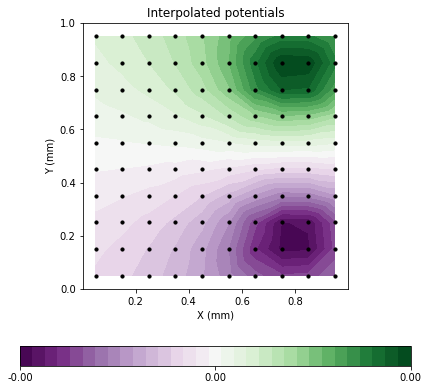

In [6]:
from scipy.interpolate import griddata

def grid(x, y, z):                                                                                                                                                                    
    x = x.flatten()                                                                                                                                                                                             
    y = y.flatten()                                                                                                                                                                                             
    z = z.flatten()                                                                                                                                                                                             
    xi, yi = np.mgrid[min(x):max(x):np.complex(0, 100),                                                                                                                                                        
                      min(y):max(y):np.complex(0, 100)]                                                                                                                                                        
    zi = griddata((x, y), z, (xi, yi), method='linear')                                                                                                                                                         
    return xi, yi, zi

pot_X, pot_Y, pot_Z = grid(ele_pos[:, 0], ele_pos[:, 1], pots)
ax = make_plot(pot_X, pot_Y, pot_Z, title='Interpolated potentials', cmap=cm.PRGn)
ax.scatter(ele_pos[:, 0], ele_pos[:, 1], 10, c='k')

### kCSD method

In [7]:
from kcsd import KCSD2D

def do_kcsd(ele_pos, pots):
    h = 50.  # distance between the electrode plane and the midslice
    sigma = 1.0 # S/m
    pots = pots.reshape((len(ele_pos), 1)) # first time point 
    k = KCSD2D(ele_pos, pots, h=h, sigma=sigma,                                                                                                                                                       
               xmin=0.0, xmax=1.0,
               ymin=0.0, ymax=1.0,
               n_src_init=1000, src_type='gauss', R_init=1.)
    return k

k = do_kcsd(ele_pos, pots)
est_csd = k.values('CSD')

Here we illustrate the most basic estimation of CSD with the `kcsd`
library. Since our example is two dimensional the relevant method is KCSD2D. For convenience we encapsulate the actual method call with parameters being set inside a function `do_kcsd` where we perform the following steps: 
* We first set h and sigma parameters of the forward model. 
* Then we restrict the potentials to the first time point of the recording. For typical experimental data the shape of this matrix would be $N_{ele} \times N_{time}$, where $N_{ele}$ is the number of electrodes and $N_{time}$ is the total number of recorded time points. 
* Next, we call the `KCSD2D` class with the relevant parameters. The only required parameters are the electrode positions, `ele_pos`, and the potentials they see, `pots`. 
* We can also provide here the parameters for the forward model, `h` and `sigma`. 
* We define a rectangular region of estimation by setting the values `xmin`, `xmax` and `ymin`, `ymax`. The number of basis functions, `n_src_init` is set to `1000`, basis functions are of the type `gauss`, and the width of the Gaussian basis source `R_init` is set to be `1`. 
* Finally, estimated `CSD` is stored as `est_csd`.
***
Observe that the estimation is not very faithful when compared to the True CSD obtained before. This is caused by the ground truth varying significantly in the scale of a single inter-electrode distance. In the next step we will use cross-validation to select better reconstruction parameters. 

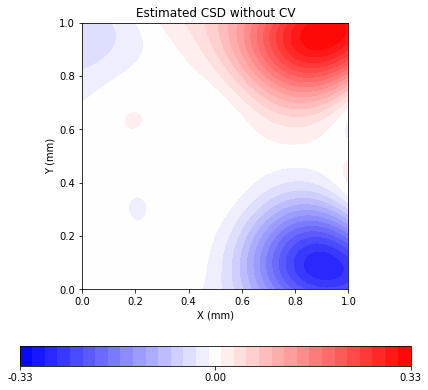

In [8]:
make_plot(k.estm_x, k.estm_y, est_csd[:, :, 0], 
          title='Estimated CSD without CV', cmap=cm.bwr) # First time point

### Cross validation

In [9]:
k.cross_validate(Rs=np.linspace(0.01, 0.15, 15))
est_csd = k.values('CSD')

No lambda given, using defaults
Cross validating R (all lambda) : 0.01
Cross validating R (all lambda) : 0.019999999999999997
Cross validating R (all lambda) : 0.03
Cross validating R (all lambda) : 0.039999999999999994
Cross validating R (all lambda) : 0.049999999999999996
Cross validating R (all lambda) : 0.05999999999999999
Cross validating R (all lambda) : 0.06999999999999999
Cross validating R (all lambda) : 0.07999999999999999
Cross validating R (all lambda) : 0.08999999999999998
Cross validating R (all lambda) : 0.09999999999999998
Cross validating R (all lambda) : 0.10999999999999997
Cross validating R (all lambda) : 0.11999999999999998
Cross validating R (all lambda) : 0.12999999999999998
Cross validating R (all lambda) : 0.13999999999999999
Cross validating R (all lambda) : 0.15
R, lambda : 0.10999999999999997 1.4677992676220675e-06


Leave-one-out cross-validation is performed with a single line command. In this procedure we scan a range of `R` values which set the size of the Gaussian basis functions and the regularization parameter $\lambda$ values. At the end of this step we obtain the optimal parameters that would correct for overfitting. The function outputs the progress of the cross-validation step and displays the optimal candidates in the last line. Alternatively, one could use the L-curve method to find these optimal parameters. 
***
We find that the estimation of the current sources obtained after cross-validation resembles the True CSD better.

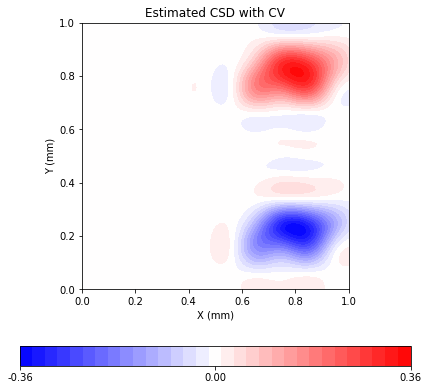

In [10]:
make_plot(k.estm_x, k.estm_y, est_csd[:, :, 0], 
          title='Estimated CSD with CV', cmap=cm.bwr) # First time point

## Noisy electrodes

Until now we assumed noise-free data, however, experimental data are always noisy. In this section we investigate how noise affects the kCSD estimation. 
* We first show how to compute reliability map which is a measure opf reconstruction quality. 
* Then we discuss reproducible generation of noisy data with varying noise amplitude. 
* Finally, we study the error in the reconstruction as a function of changing noise level.

### Reconstruction quality measure

In [11]:
def point_errors(true_csd, est_csd):
    true_csd_r = true_csd.reshape(true_csd.size, 1)
    est_csd_r = est_csd.reshape(est_csd.size, 1)
    epsilon = np.linalg.norm(true_csd_r)/np.max(abs(true_csd_r))
    err_r = abs(est_csd_r/(np.linalg.norm(est_csd_r)) -
              true_csd_r/(np.linalg.norm(true_csd_r)))
    err_r *= epsilon
    err = err_r.reshape(true_csd.shape)
    return err

error_ideal = point_errors(true_csd, est_csd)

To assess the estimation quality we measure the point-wise difference between the true sources and the sources reconstructed with the kcsd. We define a function `point_errors` which takes the `true_csd` and the `estimated_csd` as the inputs, normalizes them individually, and computes the Frobenius norm of their difference.
***
We visualize this difference as before, except we use greyscale colormap to display the intensity of the reconstruction error. For convenience we define the plotting in a function called `make_error_plot`.

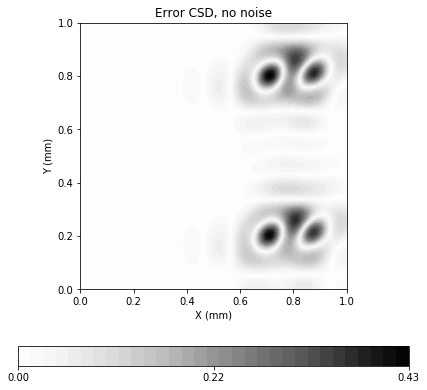

In [12]:
def make_error_plot(xx, yy, error, title='Error CSD'):
    fig = plt.figure(figsize=(7, 7))
    ax = plt.subplot(111)
    ax.set_aspect('equal')
    t_max = np.max(np.abs(error))
    levels = np.linspace(0, t_max, 32)
    im = ax.contourf(xx, yy, error, levels=levels, cmap=cm.Greys)
    ax.set_xlabel('X (mm)')
    ax.set_ylabel('Y (mm)')
    ax.set_title(title)
    ticks = np.linspace(0, t_max, 3, endpoint=True)
    plt.colorbar(im, orientation='horizontal', format='%.2f', ticks=ticks)
    return ax
    
make_error_plot(k.estm_x, k.estm_y, error_ideal, title='Error CSD, no noise')

### Noise definition

In [13]:
def add_noise(pots, noise_level=0, noise_seed=23):
    rstate = np.random.RandomState(noise_seed)
    noise = noise_level*0.01*rstate.normal(np.mean(pots), 
                                           np.std(pots), 
                                           size=(len(pots), 1))
    return pots + noise.reshape(pots.shape)

pots_noise = add_noise(pots, noise_level=15, noise_seed=23)

To study resilience of the reconstruction against the noise in a controlled way we seed the random number generator in the function `add_noise`. We consider normally distributed noise with the mean and standard deviation set by reference to the recorded potentials.

### Source reconstruction from noisy data

In [14]:
k_noise = do_kcsd(ele_pos, pots_noise)
k_noise.cross_validate(Rs=np.linspace(0.01, 0.15, 15))
estm_csd_noise = k_noise.values('CSD')
error_noise = point_errors(true_csd, estm_csd_noise)

No lambda given, using defaults
Cross validating R (all lambda) : 0.01
Cross validating R (all lambda) : 0.019999999999999997
Cross validating R (all lambda) : 0.03
Cross validating R (all lambda) : 0.039999999999999994
Cross validating R (all lambda) : 0.049999999999999996
Cross validating R (all lambda) : 0.05999999999999999
Cross validating R (all lambda) : 0.06999999999999999
Cross validating R (all lambda) : 0.07999999999999999
Cross validating R (all lambda) : 0.08999999999999998
Cross validating R (all lambda) : 0.09999999999999998
Cross validating R (all lambda) : 0.10999999999999997
Cross validating R (all lambda) : 0.11999999999999998
Cross validating R (all lambda) : 0.12999999999999998
Cross validating R (all lambda) : 0.13999999999999999
Cross validating R (all lambda) : 0.15
R, lambda : 0.01 0.0011006941712522092


With these tools we can study the effects of noise on the reconstruction. We now generate noise for a given noise level between 0 and 100, add it to the simulated potential, and estimate CSD from these noisy potentials. We can then use the error plots to compare the reconstruction with the True CSD. Notice that the parameters giving best reconstruction obtained for noisy data in general will be different from those obtained for clean potentials to compensate for noise.
***
We can display this error with the `make_error_plot` plotting function we defined earlier. Changing the `noise_level` and the `noise_seed` affects the reconstruction, but the error depends also on the sources, so changing the True CSD type to a `gauss_2d_large` or changing `csd_seed` will lead to different results.

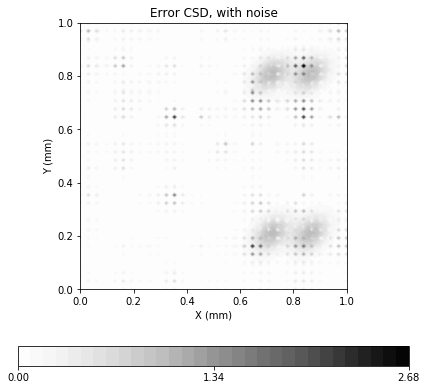

In [15]:
make_error_plot(k_noise.estm_x, k_noise.estm_y, error_noise, 
                title='Error CSD, with noise')

## Broken electrodes

It often happens that one needs to discard recordings from a subset of setup. This can happen when some electrodes are used for stimulation and cannot be used for recording, or for data managing purposes the bandwidth limitations may require a compromise between sampling rates and the number of electrodes being monitored simultaneously, or electrode may break down or get too noisy and their signals must be discarded. Here we discuss how to handle such cases and how to investigate the incurred errors in reconstruction. 
* We first show how we remove recordings from selected (broken) electrodes from considered data. 
* Then we calculate the estimation error for a given source for data from a damaged setup. 
* Finally, we compute the average error across many sources from incomplete data. 
***
Note that kCSD reconstruction is designed to work with arbitrary electrode setups. Removing specific electrodes does not change the situation significantly. We focus here on broken electrodes as we see it is a common enough situation in practice that it deserves a consideration. We want to show how one can gain intuition regarding ways and places in which reconstruction may go wrong, when we slightly disturb a setup we are familiar with.

### Remove broken electrodes

In [16]:
def remove_electrodes(ele_pos, num_broken, broken_seed=42):                                                                                                                                 
    rstate = np.random.RandomState(broken_seed)  # just a random seed                                                                                                                                        
    rmv = rstate.choice(ele_pos.shape[0], num_broken, replace=False)                                                                                                                                
    ele_pos = np.delete(ele_pos, rmv, 0)
    return ele_pos

ele_pos_new = remove_electrodes(ele_pos, 5)  # Discard 5 electrodes of 100

To test the effects of removed electrodes on reconstruction from a given setup we simulate this with a function `remove_electrodes` that takes all the electrode positions for this setup and the number of electrodes that are to be removed. In this example we remove the electrodes randomly. Like we did previously, to facilitate reproducibility we also pass a `broken_seed` variable, so that at each subsequent run the same electrodes are discarded. By changing this seed we select a different set of electrodes for removal.

### Error in estimation with broken electrodes

In [17]:
def calculate_error(csd_seed, ele_pos):
    true_csd = CSD_PROFILE(csd_at, seed=csd_seed) 
    pots = forward_method(ele_pos, csd_at, true_csd)
    k = do_kcsd(ele_pos, pots)
    k.cross_validate(Rs=np.linspace(0.01, 0.15, 15))
    err = point_errors(true_csd, k.values('CSD'))
    return k, err

k, err = calculate_error(csd_seed=15, ele_pos=ele_pos_new)

No lambda given, using defaults
Cross validating R (all lambda) : 0.01
Cross validating R (all lambda) : 0.019999999999999997
Cross validating R (all lambda) : 0.03
Cross validating R (all lambda) : 0.039999999999999994
Cross validating R (all lambda) : 0.049999999999999996
Cross validating R (all lambda) : 0.05999999999999999
Cross validating R (all lambda) : 0.06999999999999999
Cross validating R (all lambda) : 0.07999999999999999
Cross validating R (all lambda) : 0.08999999999999998
Cross validating R (all lambda) : 0.09999999999999998
Cross validating R (all lambda) : 0.10999999999999997
Cross validating R (all lambda) : 0.11999999999999998
Cross validating R (all lambda) : 0.12999999999999998
Cross validating R (all lambda) : 0.13999999999999999
Cross validating R (all lambda) : 0.15
R, lambda : 0.13999999999999999 1.333521432163324e-05


After removing the broken electrodes we compute the estimation error to gauge the effect of electrode removal on reconstruction. Here, a function `calculate_error` takes a `csd_seed` as an input, which selects a specific ground truth source, and all the remaining electrode positions, `ele_pos`. The function computes the True CSD for a `gauss_2d_small` type source, computes the potential at these electrode locations, performes kcsd estimation from these data, and computes the error in the estimation of the true csd. 

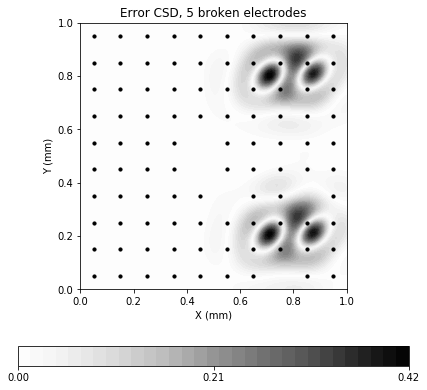

In [18]:
ax = make_error_plot(k.estm_x, k.estm_y, err, 
                     title='Error CSD, 5 broken electrodes')
ax.scatter(ele_pos_new[:, 0], ele_pos_new[:, 1], 10, c='k')

### Average error for multiple sources

In [19]:
seed_list = range(15, 17)
error_list = []
for csd_seed in seed_list:
    k, err = calculate_error(csd_seed=csd_seed, ele_pos=ele_pos_new)
    error_list.append(err)
avg_error = sum(error_list) / len(error_list)

No lambda given, using defaults
Cross validating R (all lambda) : 0.01
Cross validating R (all lambda) : 0.019999999999999997
Cross validating R (all lambda) : 0.03
Cross validating R (all lambda) : 0.039999999999999994
Cross validating R (all lambda) : 0.049999999999999996
Cross validating R (all lambda) : 0.05999999999999999
Cross validating R (all lambda) : 0.06999999999999999
Cross validating R (all lambda) : 0.07999999999999999
Cross validating R (all lambda) : 0.08999999999999998
Cross validating R (all lambda) : 0.09999999999999998
Cross validating R (all lambda) : 0.10999999999999997
Cross validating R (all lambda) : 0.11999999999999998
Cross validating R (all lambda) : 0.12999999999999998
Cross validating R (all lambda) : 0.13999999999999999
Cross validating R (all lambda) : 0.15
R, lambda : 0.13999999999999999 1.333521432163324e-05
No lambda given, using defaults
Cross validating R (all lambda) : 0.01
Cross validating R (all lambda) : 0.019999999999999997
Cross validating R (

As we can see, the estimation error depends on the test current sources used. To better understand the effects of the setup we compute the average error across multiple sources. As an example here we show this for two seeds. In principle, any type and number of sources may be tested, as we showed before in analysis of reliability maps. This step is computationally expensive, however, it would normally be carried out only once for a given electrode design configuration. We believe this approach offers useful diagnostics and builds intuition regarding the estimation power for the given setup.

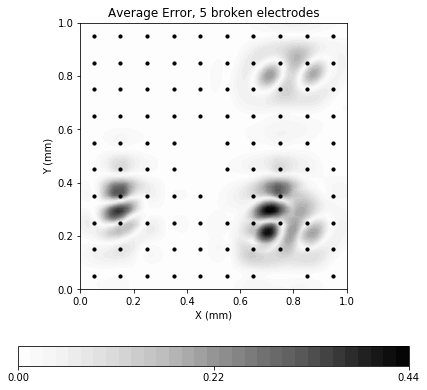

In [20]:
ax = make_error_plot(k.estm_x, k.estm_y, avg_error, 
                     title='Average Error, 5 broken electrodes')
ax.scatter(ele_pos_new[:, 0], ele_pos_new[:, 1], 10, c='k')